# Dự án phân loại cá sử dụng PyTorch

Notebook này triển khai dự án phân loại 31 loài cá khác nhau sử dụng PyTorch. Dataset bao gồm 8791 ảnh huấn luyện và 2751 ảnh kiểm tra.

## Loài cá trong dataset
```
'Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp','Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia'
```

## 1. Imports và Cài đặt môi trường

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
# Kiểm tra GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

    
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Thiết lập seed cho tính tái tạo
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
CUDA Version: 11.8


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
# Kiểm tra GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

    
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Thiết lập seed cho tính tái tạo
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
CUDA Version: 11.8


## 2. Utility Functions cho Xử lý Dữ liệu

Các hàm này sẽ xử lý và chuẩn bị dữ liệu cho việc huấn luyện mô hình.

In [3]:
def create_data_loaders(train_dir, test_dir, batch_size=32, img_size=(224, 224)):
    """
    Tạo DataLoader cho tập huấn luyện và kiểm tra.
    Args:
        train_dir (str): Thư mục chứa ảnh huấn luyện
        test_dir (str): Thư mục chứa ảnh kiểm tra
        batch_size (int): Batch size
        img_size (tuple): Kích thước ảnh
    Returns:
        train_loader, test_loader, class_to_idx
    """
    train_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
    ])

    test_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                            num_workers=4, pin_memory=True)

    return train_loader, test_loader, train_dataset.class_to_idx

def get_class_names(class_to_idx):
    """
    Lấy danh sách tên lớp theo thứ tự index.
    Args:
        class_to_idx (dict): Dict ánh xạ class name -> index
    Returns:
        List tên lớp theo thứ tự
    """
    return [name for name, _ in sorted(class_to_idx.items(), key=lambda item: item[1])]

## 3. Định nghĩa Mô hình

Chúng ta sẽ định nghĩa hai mô hình:
1. Mô hình transfer learning sử dụng ResNet18 pretrained
2. Mô hình CNN tùy chỉnh từ đầu

In [4]:
# def create_fish_classifier(num_classes):
#     """
#     Tạo mô hình ResNet18 pretrained cho phân loại cá
#     """
#     model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
#     num_ftrs = model.fc.in_features
#     model.fc = nn.Linear(num_ftrs, num_classes)
#     return model
# Thay đổi từ ResNet18 sang ResNet34 hoặc ResNet50
def create_fish_classifier(num_classes):
    model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model
class FishClassifier(nn.Module):
    """
    Mô hình CNN tùy chỉnh cho phân loại cá
    """
    def __init__(self, num_classes=31):
        super(FishClassifier, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Sử dụng adaptive pooling thay vì hardcoded size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.adaptive_pool(x)
        x = self.fc(x)
        return x

## 4. Huấn luyện và Đánh giá Mô hình

In [ ]:
def train_model(train_loader, test_loader, device, model_type='resnet18', 
                num_classes=31, epochs=3, accumulation_steps=2):
    """
    Huấn luyện mô hình phân loại cá với mixed precision và gradient accumulation
    
    Args:
        train_loader: DataLoader cho tập huấn luyện
        test_loader: DataLoader cho tập kiểm tra
        device: thiết bị (CPU/GPU)
        model_type: loại mô hình ('resnet18', 'resnet34', hoặc 'custom')
        num_classes: số lượng lớp
        epochs: số epoch huấn luyện
        accumulation_steps: Số bước tích lũy gradient (tăng hiệu quả batch size)
    Returns:
        model: mô hình đã huấn luyện
    """
    # Khởi tạo mô hình
    if model_type == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        print("Sử dụng mô hình ResNet18 với transfer learning")
    elif model_type == 'resnet34':
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        print("Sử dụng mô hình ResNet34 với transfer learning")
    else:
        model = FishClassifier(num_classes)
        print("Sử dụng mô hình CNN tùy chỉnh")
    
    model = model.to(device)

    # Hiển thị thông tin mô hình
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Tổng số tham số: {total_params:,}")
    print(f"Số tham số có thể học: {trainable_params:,}")
    
    # Loss function và optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6, verbose=True
    )
    
    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler()
    
    # Các biến theo dõi quá trình huấn luyện
    best_acc = 0.0
    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], []
    
    # Early stopping
    patience = 5
    no_improve_epochs = 0
    
    # Hiển thị thông tin GPU ban đầu
    check_gpu_usage()

    for epoch in range(epochs):
        # ===== Training phase =====
        model.train()
        running_loss, running_corrects = 0.0, 0
        optimizer.zero_grad()  # Đặt ở ngoài vòng lặp batch với gradient accumulation
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for i, (inputs, labels) in enumerate(train_bar):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Sử dụng autocast để huấn luyện với FP16
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels) / accumulation_steps  # Chia loss để tương thích với accumulation
            
            # Sử dụng scaler để scale loss và thực hiện backward
            scaler.scale(loss).backward()
            
            # Gradient accumulation - chỉ cập nhật sau mỗi accumulation_steps
            if (i + 1) % accumulation_steps == 0 or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            # Tính toán metrics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0) * accumulation_steps  # Điều chỉnh loss
            running_corrects += torch.sum(preds == labels.data)
            
            # Hiển thị metrics hiện tại
            current_loss = loss.item() * accumulation_steps
            current_acc = torch.sum(preds == labels.data).double() / inputs.size(0)
            lr = optimizer.param_groups[0]['lr']
            train_bar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.4f}", lr=f"{lr:.6f}")
            
            # Giải phóng bộ nhớ
            del inputs, labels, outputs, loss
            
        # Tính toán metrics cho epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc.item())
        
        # ===== Validation phase =====
        model.eval() # Chuyển sang chế độ eval 
        val_loss, val_corrects = 0.0, 0
        
        val_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Không cần autocast trong eval mode với no_grad
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                
                # Hiển thị metrics hiện tại
                current_loss = loss.item()
                current_acc = torch.sum(preds == labels.data).double() / inputs.size(0)
                val_bar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.4f}")
                
                # Giải phóng bộ nhớ
                del inputs, labels, outputs, loss
        
        # Tính toán metrics cho validation
        val_loss = val_loss / len(test_loader.dataset)
        val_acc = val_corrects.double() / len(test_loader.dataset)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc.item())
        
        # Cập nhật learning rate
        scheduler.step(val_loss)
        
        # Hiển thị kết quả epoch
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Lưu mô hình tốt nhất và early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_acc': best_acc,
                'val_loss': val_loss,
                'class_to_idx': {i: class_name for i, class_name in enumerate(get_class_names(test_loader.dataset.class_to_idx))}
            }, f'best_{model_type}_model.pth')
            
            print(f"Đã lưu mô hình tốt nhất với độ chính xác: {val_acc:.4f}")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"Không cải thiện độ chính xác trong {no_improve_epochs} epochs")
            # Kiểm tra early stopping
            if no_improve_epochs >= patience:
                print(f"Early stopping tại epoch {epoch+1}")
                break
        
        # Kiểm tra sử dụng GPU
        check_gpu_usage()
        
        # Giải phóng bộ nhớ GPU sau mỗi epoch
        torch.cuda.empty_cache()
    
    # Lưu mô hình cuối cùng
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'final_acc': val_acc,
        'val_loss': val_loss,
        'class_to_idx': {i: class_name for i, class_name in enumerate(get_class_names(test_loader.dataset.class_to_idx))}
    }, f'fish_classifier_{model_type}_final.pth')
    
    # Vẽ biểu đồ quá trình huấn luyện
    plot_training_history(train_acc_list, val_acc_list, train_loss_list, val_loss_list, model_type)
    
    return model

def check_gpu_usage():
    """Hiển thị thông tin sử dụng GPU"""
    if torch.cuda.is_available():
        print("\n=== GPU Usage Information ===")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        allocated = torch.cuda.memory_allocated(0) / 1024**3
        max_allocated = torch.cuda.max_memory_allocated(0) / 1024**3
        reserved = torch.cuda.memory_reserved(0) / 1024**3
        
        print(f"Memory Allocated: {allocated:.2f} GB")
        print(f"Max Memory Allocated: {max_allocated:.2f} GB")
        print(f"Memory Reserved: {reserved:.2f} GB")
        print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
        print(f"Memory Utilization: {(allocated / (torch.cuda.get_device_properties(0).total_memory / 1024**3)) * 100:.2f}%")
        print("=============================\n")

def plot_training_history(train_acc, val_acc, train_loss, val_loss, model_type):
    """
    Vẽ biểu đồ quá trình huấn luyện
    """
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_type}_training_history.png')
    plt.show()

## 5. Huấn luyện mô hình

Chúng ta sẽ tiến hành huấn luyện mô hình ResNet18 pretrained

In [6]:
# Đường dẫn dataset
TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'

# Tham số huấn luyện
batch_size = 16  # Tăng lên so với 8 nếu GPU cho phép
epochs = 30
img_size = (224, 224)

# Tạo DataLoader
train_loader, test_loader, class_to_idx = create_data_loaders(
    TRAIN_DIR, TEST_DIR, batch_size=batch_size, img_size=img_size
)

# Lấy danh sách tên lớp
class_names = get_class_names(class_to_idx)
print(f"Số lượng lớp: {len(class_names)}")
print(f"Tên các lớp: {class_names}")

Số lượng lớp: 31
Tên các lớp: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


In [ ]:
# Với batch_size = 16 và accumulation_steps = 2, đang mô phỏng batch_size 32
model = train_model(
    train_loader, # train_loader: DataLoader cho tập huấn luyện
    test_loader, # test_loader: DataLoader cho tập kiểm tra
    device, # device: thiết bị (CPU/GPU)
    model_type='resnet34',  # Sử dụng mô hình lớn hơn
    num_classes=len(class_names), # số lượng lớp
    epochs=epochs, # epochs: số epoch huấn luyện
    accumulation_steps=2  # accumulation_steps: 2 để mô phỏng batch_size lớn hơn
)

NameError: name 'train_model' is not defined

## 6. Đánh giá mô hình chi tiết

In [ ]:
def evaluate_model(model, test_loader, device, class_names):
    """
    Đánh giá chi tiết mô hình và tạo confusion matrix
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate accuracy
    accuracy = np.mean(all_preds == all_labels)
    print(f"Độ chính xác tổng thể: {accuracy:.4f}")
    
    # Create confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(20, 18))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    # Add labels
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    
    # Add values to the plot
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()
    
    # Print classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:")
    print(report)
    
    return accuracy, cm, report

In [ ]:
#Đánh giá mô hình, vẽ sơ đồ confusion matrix và in báo cáo phân loại
accuracy, cm, report = evaluate_model(model, test_loader, device, class_names)
# Lưu confusion matrix
np.save('confusion_matrix.npy', cm)
# Lưu báo cáo phân loại
with open('classification_report.txt', 'w') as f:
    f.write(report)

NameError: name 'model' is not defined

## 7. Dự đoán trên ảnh mới

In [ ]:
def test_flat_directory(model, test_dir, transform, class_names, device):
    """
    Kiểm tra mô hình trên thư mục test chứa các file ảnh trực tiếp
    Tên lớp được suy ra từ tên file
    """
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import os
    import numpy as np
    
    model.eval()
    
    # Biến để theo dõi kết quả
    all_true_labels = []
    all_predictions = []
    all_image_paths = []
    
    # Kiểm tra thư mục test có tồn tại không
    if not os.path.exists(test_dir):
        print(f"Lỗi: Thư mục test '{test_dir}' không tồn tại!")
        return None, None, [], [], []
    
    # Lấy danh sách các file ảnh
    image_files = [f for f in os.listdir(test_dir) 
                   if os.path.isfile(os.path.join(test_dir, f)) and 
                   f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"Lỗi: Không tìm thấy file ảnh nào trong '{test_dir}'")
        return None, None, [], [], []
    
    print(f"Tìm thấy {len(image_files)} file ảnh")
    
    # Xử lý từng ảnh
    for img_file in image_files:
        img_path = os.path.join(test_dir, img_file)
        
        # Cố gắng suy ra lớp từ tên file
        true_class = None
        for class_name in class_names:
            if class_name in img_file:
                true_class = class_name
                break
                
        if true_class is None:
            print(f"  Bỏ qua {img_file}: Không thể xác định lớp từ tên file")
            continue
            
        class_idx = class_names.index(true_class)
            
        # Đọc và biến đổi ảnh
        try:
            img = Image.open(img_path)
            img_tensor = transform(img).unsqueeze(0).to(device)
            
            # Dự đoán
            with torch.no_grad():
                outputs = model(img_tensor)
                probs = F.softmax(outputs, dim=1)[0]
                _, pred = torch.max(outputs, 1)
            
            # Lưu kết quả
            pred_idx = pred.item()
            predicted_class = class_names[pred_idx]
            confidence = probs[pred_idx].item()
            
            all_true_labels.append(class_idx)
            all_predictions.append(pred_idx)
            all_image_paths.append(img_path)
            
            # In kết quả cho ảnh này
            result = "✓" if class_idx == pred_idx else "✗"
            print(f"  {result} Ảnh: {img_file}, Thực tế: {true_class}, Dự đoán: {predicted_class}, Độ tin cậy: {confidence:.4f}")
            
        except Exception as e:
            print(f"  Lỗi xử lý {img_path}: {str(e)}")
    
    # Kiểm tra xem có dự đoán nào không
    if not all_true_labels:
        print("\nKhông có dự đoán nào được thực hiện.")
        return None, None, [], [], []
    
    # Tính độ chính xác
    all_true_labels = np.array(all_true_labels)
    all_predictions = np.array(all_predictions)
    correct = np.sum(all_true_labels == all_predictions)
    total = len(all_true_labels)
    accuracy = correct / total if total > 0 else 0
    
    print("\nKết quả kiểm tra:")
    print(f"Tổng số ảnh: {total}")
    print(f"Dự đoán đúng: {correct}")
    print(f"Độ chính xác: {accuracy:.4f}")
    
    #hiển thị ảnh
    try:
        fig, axes = plt.subplots(1, 5, figsize=(15, 4))
        for i in range(5):
            img = Image.open(all_image_paths[i])
            axes[i].imshow(img)
            axes[i].set_title(f"Thực tế: {class_names[all_true_labels[i]]}\nDự đoán: {class_names[all_predictions[i]]}")
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Lỗi khi hiển thị ảnh: {str(e)}")
    # Tạo ma trận nhầm lẫn
    cm = confusion_matrix(all_true_labels, all_predictions)
    
    # Vẽ ma trận nhầm lẫn
    try:
        plt.figure(figsize=(15, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Dự đoán')
        plt.ylabel('Thực tế')
        plt.title('Ma trận nhầm lẫn')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Lỗi khi vẽ ma trận nhầm lẫn: {str(e)}")
        print("Ma trận nhầm lẫn:")
        print(cm)
    
    # Tìm ảnh phân loại sai
    misclassified_indices = np.where(all_true_labels != all_predictions)[0]
    misclassified = [(all_image_paths[i], 
                     class_names[all_true_labels[i]], 
                     class_names[all_predictions[i]]) 
                    for i in misclassified_indices]
    
    # Hiển thị một số ví dụ phân loại sai
    if misclassified:
        print(f"\nTổng số ảnh phân loại sai: {len(misclassified)}")
        print("Một số ví dụ phân loại sai:")
        n_examples = min(5, len(misclassified))
        
        try:
            fig, axes = plt.subplots(1, n_examples, figsize=(15, 4))
            if n_examples == 1:
                axes = [axes]
                
            for i, (img_path, true_label, pred_label) in enumerate(misclassified[:n_examples]):
                img = Image.open(img_path)
                axes[i].imshow(img)
                axes[i].set_title(f"Thực tế: {true_label}\nDự đoán: {pred_label}")
                axes[i].axis('off')
                
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Lỗi khi hiển thị ảnh phân loại sai: {str(e)}")
    else:
        print("\nKhông có ảnh nào bị phân loại sai!")
    
    return accuracy, cm, all_true_labels, all_predictions, misclassified

def predict_all_images(model, test_dir, transform, class_names, device):
    """
    Dự đoán tất cả ảnh trong thư mục, bất kể có xác định được lớp từ tên file hay không
    """
    import os
    import matplotlib.pyplot as plt
    
    import torch
    import torch.nn.functional as F
    import numpy as np
    from PIL import Image
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    from PIL import Image 
    
    model.eval()
    
    # Biến để theo dõi kết quả
    all_predictions = []
    all_image_paths = []
    all_confidences = []
    
    # Biến đặc biệt để đánh giá khi biết lớp thực tế
    known_true_labels = []
    known_predictions = []
    known_image_paths = []
    
    # Kiểm tra thư mục test có tồn tại không
    if not os.path.exists(test_dir):
        print(f"Lỗi: Thư mục test '{test_dir}' không tồn tại!")
        return None, None, [], [], []
    
    # Lấy danh sách các file ảnh
    image_files = [f for f in os.listdir(test_dir) 
                   if os.path.isfile(os.path.join(test_dir, f)) and 
                   f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"Lỗi: Không tìm thấy file ảnh nào trong '{test_dir}'")
        return None, None, [], [], []
    
    print(f"Tìm thấy {len(image_files)} file ảnh")
    
    # Xử lý từng ảnh
    for img_file in image_files:
        img_path = os.path.join(test_dir, img_file)
        
        # Cố gắng suy ra lớp từ tên file (nếu có thể)
        true_class = None
        for class_name in class_names:
            if class_name in img_file:
                true_class = class_name
                break
                
        # Đọc và biến đổi ảnh
        try:
            img = Image.open(img_path)
            img_tensor = transform(img).unsqueeze(0).to(device)
            
            # Dự đoán
            with torch.no_grad():
                outputs = model(img_tensor)
                probs = F.softmax(outputs, dim=1)[0]
                _, pred = torch.max(outputs, 1)
            
            # Lưu kết quả
            pred_idx = pred.item()
            predicted_class = class_names[pred_idx]
            confidence = probs[pred_idx].item()
            
            all_predictions.append(pred_idx)
            all_image_paths.append(img_path)
            all_confidences.append(confidence)
            
            # Nếu biết lớp thực tế, thêm vào danh sách đánh giá
            if true_class is not None:
                class_idx = class_names.index(true_class)
                known_true_labels.append(class_idx)
                known_predictions.append(pred_idx)
                known_image_paths.append(img_path)
                
                # In kết quả với đánh giá đúng/sai
                result = "✓" if class_idx == pred_idx else "✗"
                print(f"  {result} Ảnh: {img_file}, Thực tế: {true_class}, Dự đoán: {predicted_class}, Độ tin cậy: {confidence:.4f}")
            else:
                # In kết quả dự đoán mà không đánh giá
                print(f"  ? Ảnh: {img_file}, Dự đoán: {predicted_class}, Độ tin cậy: {confidence:.4f}")
            
        except Exception as e:
            print(f"  Lỗi xử lý {img_path}: {str(e)}")
    
    # Kiểm tra xem có dự đoán nào không
    if not all_predictions:
        print("\nKhông có dự đoán nào được thực hiện.")
        return None, None, [], [], []
    
    # Tính độ chính xác cho những ảnh có thể xác định lớp
    accuracy = None
    cm = None
    if known_true_labels:
        known_true_labels = np.array(known_true_labels)
        known_predictions = np.array(known_predictions)
        correct = np.sum(known_true_labels == known_predictions)
        total = len(known_true_labels)
        accuracy = correct / total if total > 0 else 0
        
        print("\nKết quả đánh giá (chỉ tính những ảnh xác định được lớp):")
        print(f"Tổng số ảnh có nhãn: {total}")
        print(f"Dự đoán đúng: {correct}")
        print(f"Độ chính xác: {accuracy:.4f}")
        
        # Tạo ma trận nhầm lẫn
        cm = confusion_matrix(known_true_labels, known_predictions)
        
        # Vẽ ma trận nhầm lẫn
        try:
            plt.figure(figsize=(15, 12))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=class_names, yticklabels=class_names)
            plt.xlabel('Dự đoán')
            plt.ylabel('Thực tế')
            plt.title('Ma trận nhầm lẫn (chỉ cho ảnh có nhãn)')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Lỗi khi vẽ ma trận nhầm lẫn: {str(e)}")
            print("Ma trận nhầm lẫn:")
            print(cm)
        
        # Tìm ảnh phân loại sai
        misclassified_indices = np.where(known_true_labels != known_predictions)[0]
        misclassified = [(known_image_paths[i], 
                         class_names[known_true_labels[i]], 
                         class_names[known_predictions[i]]) 
                        for i in misclassified_indices]
        
        # Hiển thị một số ví dụ phân loại sai
        if misclassified:
            print(f"\nTổng số ảnh phân loại sai: {len(misclassified)}")
            print("Một số ví dụ phân loại sai:")
            n_examples = min(5, len(misclassified))
            
            try:
                fig, axes = plt.subplots(1, n_examples, figsize=(15, 4))
                if n_examples == 1:
                    axes = [axes]
                    
                for i, (img_path, true_label, pred_label) in enumerate(misclassified[:n_examples]):
                    img = Image.open(img_path)
                    axes[i].imshow(img)
                    axes[i].set_title(f"Thực tế: {true_label}\nDự đoán: {pred_label}")
                    axes[i].axis('off')
                    
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Lỗi khi hiển thị ảnh phân loại sai: {str(e)}")
        else:
            print("\nKhông có ảnh nào bị phân loại sai!")
    else:
        print("\nKhông có ảnh nào xác định được lớp thực tế để đánh giá độ chính xác.")
    
    # Hiển thị phân phối dự đoán cho tất cả ảnh
    print("\nPhân phối dự đoán cho tất cả ảnh:")
    all_predictions = np.array(all_predictions)
    for i, class_name in enumerate(class_names):
        count = np.sum(all_predictions == i)
        print(f"  {class_name}: {count} ảnh")
        
    # Hiển thị một vài ảnh và dự đoán
    print("\nHiển thị một số ví dụ dự đoán:")
    n_examples = min(5, len(all_image_paths))
    try:
        fig, axes = plt.subplots(1, n_examples, figsize=(15, 4))
        if n_examples == 1:
            axes = [axes]
            
        for i in range(n_examples):
            img_path = all_image_paths[i]
            pred_class = class_names[all_predictions[i]]
            confidence = all_confidences[i]
            
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"Dự đoán: {pred_class}\nĐộ tin cậy: {confidence:.4f}")
            axes[i].axis('off')
            
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Lỗi khi hiển thị ảnh: {str(e)}")
    
    return accuracy, cm, known_true_labels, known_predictions, misclassified

In [15]:
# # Tạo transform cho dự đoán
# predict_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# # Ví dụ: dự đoán ảnh mới
# image_path = "dataset/test/Big Head Carp/Big Head Carp 7.jpg"#E:\code\fish_torch\dataset\test\Bangus\Bangus 19.jpg
# top5_classes, top5_probs = predict_image(model, image_path, predict_transform, class_names, device)

Using device: cuda
Số lượng lớp: 31
Tìm thấy 1 file ảnh
  ✓ Ảnh: Goby.jpg, Thực tế: Goby, Dự đoán: Goby, Độ tin cậy: 0.9936

Kết quả kiểm tra:
Tổng số ảnh: 1
Dự đoán đúng: 1
Độ chính xác: 1.0000
Lỗi khi hiển thị ảnh: list index out of range


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


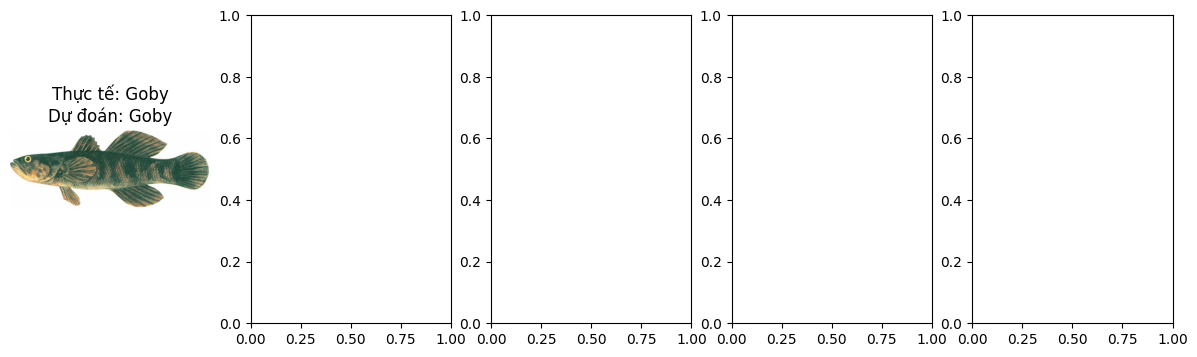

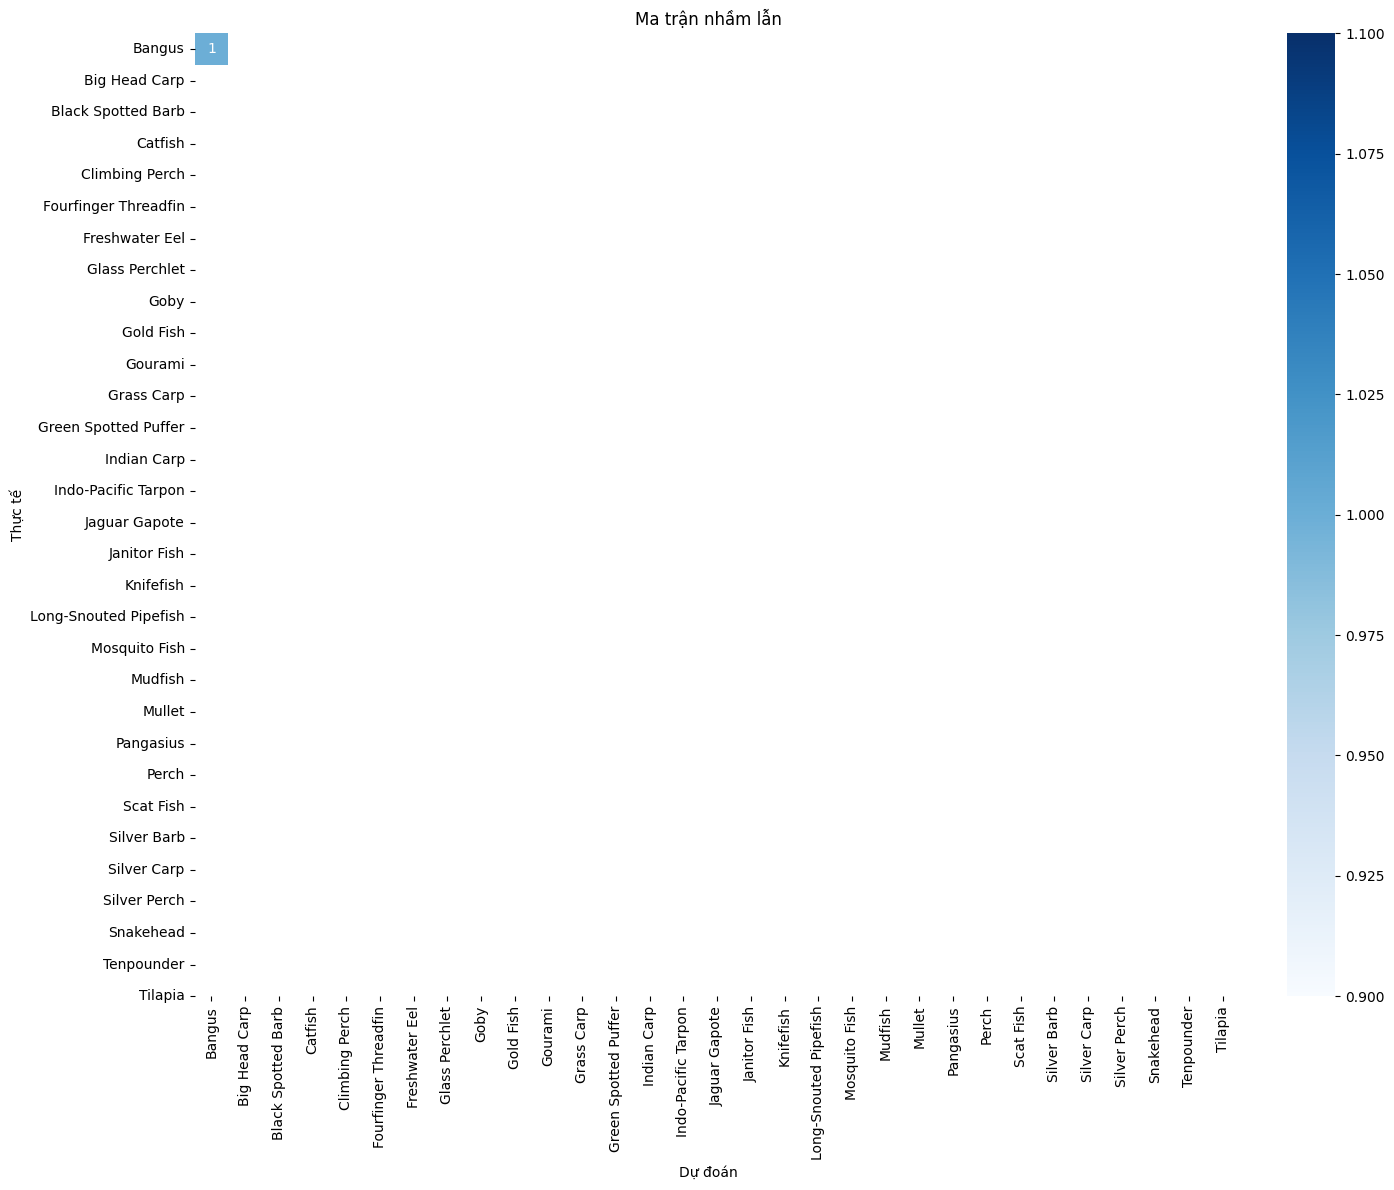


Không có ảnh nào bị phân loại sai!


In [22]:
#run ko cần train lại
import torch
import torch.nn as nn
from torchvision import transforms, models
import torch.nn.functional as F
import matplotlib.pyplot as plt
# Định nghĩa device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Tạo biến class_names từ file checkpoint
test_dir = "test2"
checkpoint = torch.load("best_resnet34_model.pth")

# Lấy class_names từ checkpoint nếu có
if isinstance(checkpoint, dict) and 'class_to_idx' in checkpoint:
    class_to_idx = checkpoint['class_to_idx'] 
    class_names = list(class_to_idx.values())
    # Đảm bảo thứ tự đúng theo index
    class_names = [class_name for _, class_name in sorted(class_to_idx.items(), key=lambda x: int(x[0]))]
else:
    # Nếu không có trong checkpoint, bạn cần đảm bảo thứ tự chính xác
    class_names = ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 
                  'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 
                  'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 
                  'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 
                  'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 
                  'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 
                  'Scat Fish', 'Silver Barb', 'Silver Carp','Silver Perch', 
                  'Snakehead', 'Tenpounder', 'Tilapia']

# In ra để xác nhận
print(f"Số lượng lớp: {len(class_names)}")

# Tạo transform cho dự đoán
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Tạo lại mô hình với kiến trúc tương tự mô hình đã huấn luyện
model = models.resnet34(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(class_names))

# Nạp mô hình từ file
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)

# Đưa mô hình lên GPU
model = model.to(device)

# Thêm import PIL.Image vào trước khi gọi hàm
from PIL import Image

# Kiểm tra thư mục test với các file trực tiếp
accuracy, cm, true_labels, predictions, misclassified = test_flat_directory(
    model, test_dir, test_transform, class_names, device
)
# # tao transform cho dự đoán
# import torch
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# predict_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])
# # Nạp mô hình từ file
# checkpoint = torch.load("best_resnet34_model.pth")
# if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
#     model.load_state_dict(checkpoint['model_state_dict'])
# else:
#     model.load_state_dict(checkpoint)

# # Đưa mô hình lên GPU
# model = model.to(device)
# # Dự đoán tất cả ảnh trong thư mục
# accuracy, cm, true_labels, predictions, misclassified = predict_all_images(
#     model, test_dir, predict_transform, class_names, device
# )

In [ ]:
# import torch
# from torchvision import transforms
# import torch.nn.functional as F

# test_dir = "test2"  
# # Tạo transform cho dự đoán
# test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])
# # Nạp mô hình từ file
# checkpoint = torch.load("best_resnet34_model.pth")
# if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
#     model.load_state_dict(checkpoint['model_state_dict'])
# else:
#     model.load_state_dict(checkpoint)

# # Đưa mô hình lên GPU
# model = model.to(device)
# # Kiểm tra thư mục test với các file trực tiếp
# accuracy, cm, true_labels, predictions, misclassified = test_flat_directory(
#     model, test_dir, test_transform, class_names, device
# )

NameError: name 'nn' is not defined

Tìm thấy 24 file ảnh
  ✓ Ảnh: Bangus 19.jpg, Thực tế: Bangus, Dự đoán: Bangus, Độ tin cậy: 1.0000
  ✓ Ảnh: Bangus 21.jpg, Thực tế: Bangus, Dự đoán: Bangus, Độ tin cậy: 0.9998
  ✓ Ảnh: Bangus 32.jpg, Thực tế: Bangus, Dự đoán: Bangus, Độ tin cậy: 0.9999
  ✓ Ảnh: Bangus 35.jpg, Thực tế: Bangus, Dự đoán: Bangus, Độ tin cậy: 1.0000
  ✓ Ảnh: Bangus 42.jpg, Thực tế: Bangus, Dự đoán: Bangus, Độ tin cậy: 1.0000
  ✓ Ảnh: Black Spotted Barb 15.jpg, Thực tế: Black Spotted Barb, Dự đoán: Black Spotted Barb, Độ tin cậy: 1.0000
  ✓ Ảnh: Black Spotted Barb 24.jpg, Thực tế: Black Spotted Barb, Dự đoán: Black Spotted Barb, Độ tin cậy: 0.9997
  ✓ Ảnh: Black Spotted Barb 33.jpg, Thực tế: Black Spotted Barb, Dự đoán: Black Spotted Barb, Độ tin cậy: 0.9997
  ✓ Ảnh: Black Spotted Barb 34.jpg, Thực tế: Black Spotted Barb, Dự đoán: Black Spotted Barb, Độ tin cậy: 0.9999
  ✓ Ảnh: Black Spotted Barb 8.jpg, Thực tế: Black Spotted Barb, Dự đoán: Black Spotted Barb, Độ tin cậy: 0.9997
  ✓ Ảnh: Gold Fish 22.jpg, Thự

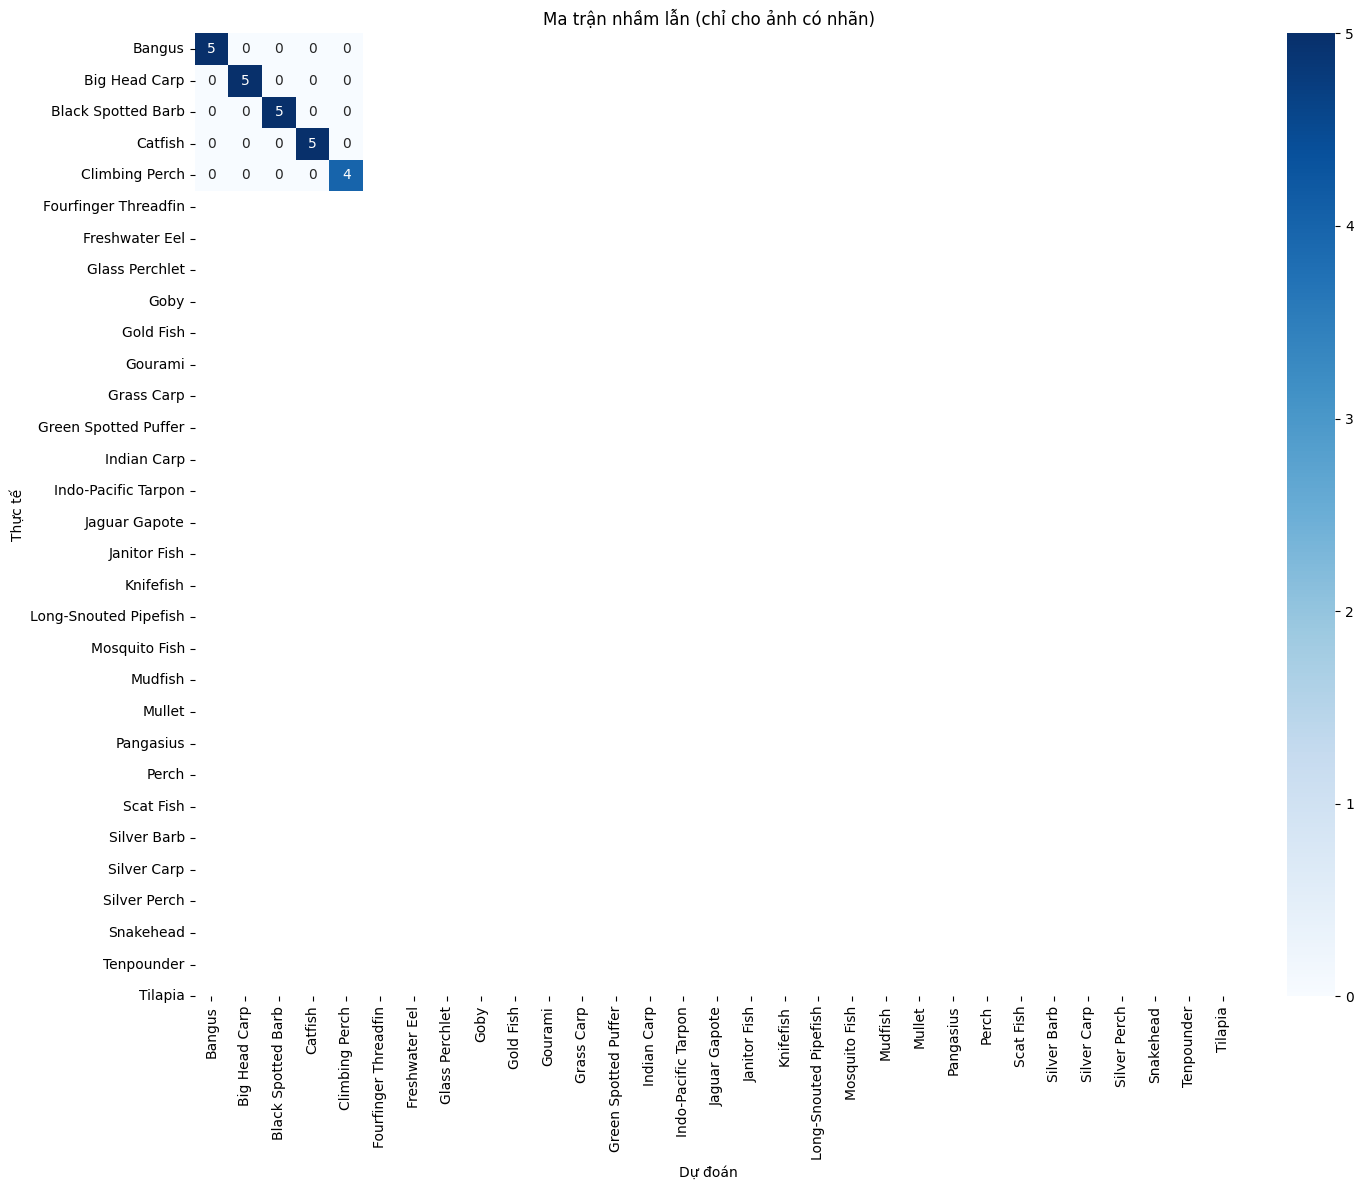


Không có ảnh nào bị phân loại sai!

Phân phối dự đoán cho tất cả ảnh:
  Bangus: 5 ảnh
  Big Head Carp: 0 ảnh
  Black Spotted Barb: 5 ảnh
  Catfish: 0 ảnh
  Climbing Perch: 0 ảnh
  Fourfinger Threadfin: 0 ảnh
  Freshwater Eel: 0 ảnh
  Glass Perchlet: 0 ảnh
  Goby: 0 ảnh
  Gold Fish: 5 ảnh
  Gourami: 0 ảnh
  Grass Carp: 0 ảnh
  Green Spotted Puffer: 0 ảnh
  Indian Carp: 0 ảnh
  Indo-Pacific Tarpon: 5 ảnh
  Jaguar Gapote: 0 ảnh
  Janitor Fish: 0 ảnh
  Knifefish: 0 ảnh
  Long-Snouted Pipefish: 0 ảnh
  Mosquito Fish: 0 ảnh
  Mudfish: 0 ảnh
  Mullet: 0 ảnh
  Pangasius: 0 ảnh
  Perch: 0 ảnh
  Scat Fish: 0 ảnh
  Silver Barb: 0 ảnh
  Silver Carp: 0 ảnh
  Silver Perch: 0 ảnh
  Snakehead: 0 ảnh
  Tenpounder: 4 ảnh
  Tilapia: 0 ảnh

Hiển thị một số ví dụ dự đoán:


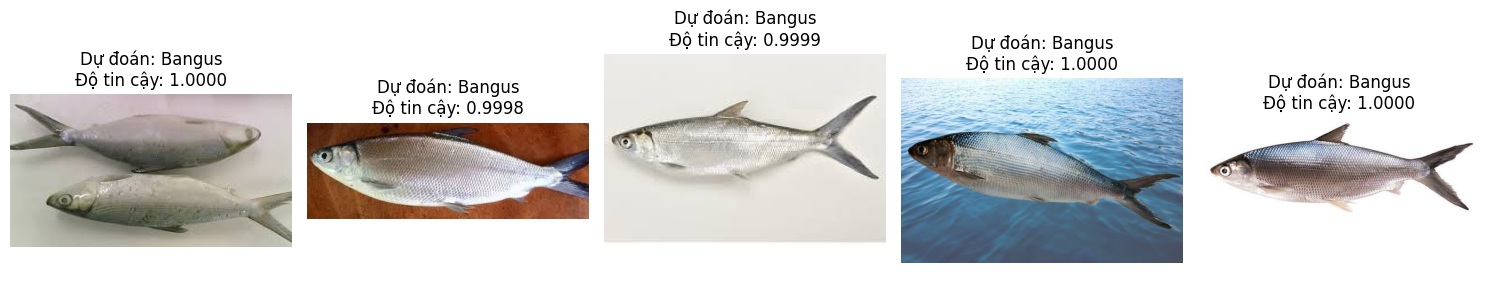

In [ ]:
# tao transform cho dự đoán
predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
# Nạp mô hình từ file
checkpoint = torch.load("best_resnet34_model.pth")
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)

# Đưa mô hình lên GPU
model = model.to(device)
# Dự đoán tất cả ảnh trong thư mục
accuracy, cm, true_labels, predictions, misclassified = predict_all_images(
    model, test_dir, predict_transform, class_names, device
)

In [ ]:
# import torch
# import torchvision.models as models

# # Khởi tạo mô hình ResNet34
# model = models.resnet34(pretrained=False)  

# # Điều chỉnh lớp đầu ra cho số lượng lớp
# num_classes = len(class_names)  # Thay thế bằng số lượng lớp
# model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# # Tải state_dict từ file
# checkpoint = torch.load("best_resnet34_model.pth", map_location=torch.device('cpu'))

# # Có hai trường hợp phổ biến:
# # Trường hợp 1: Nếu file chứa state_dict trực tiếp
# if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
#     model.load_state_dict(checkpoint['state_dict'])
# # Trường hợp 2: Nếu file chính là state_dict
# elif isinstance(checkpoint, dict):
#     model.load_state_dict(checkpoint)

# # Đặt mô hình ở chế độ đánh giá
# model.eval()

# # Tạo input dummy
# dummy_input = torch.randn(1, 3, 224, 224)

# # Xuất mô hình sang ONNX
# torch.onnx.export(model, dummy_input, "fish_model.onnx",
#                   input_names=['input'], output_names=['output'],
#                   dynamic_axes={'input': {0: 'batch_size'},
#                                'output': {0: 'batch_size'}})

# print("Đã chuyển đổi mô hình sang ONNX thành công!")

RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "epoch", "model_state_dict", "optimizer_state_dict", "scheduler_state_dict", "best_acc", "val_loss", "class_to_idx". 

## 8. Thử nghiệm với mô hình tùy chỉnh (Optional)

In [ ]:
# Huấn luyện mô hình CNN tùy chỉnh

# custom_model = train_model(
#     train_loader, 
#     test_loader, 
#     device, 
#     model_type='custom',
#     num_classes=len(class_names), 
#     epochs=epochs
# )